In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import datetime as dt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score,r2_score,mean_absolute_error,mean_squared_error,accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
from plotly.offline import iplot, init_notebook_mode
import pickle
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
from datetime import datetime, timedelta
import plotly.express as px

In [2]:
path = 'C:/Users/Acer/project-pattern/project-pattern-mo/Atliq_Mart_Challenge_1'
fact_order_lines_df=pd.read_csv(path+"/fact_order_lines.csv")
fact_orders_aggregate_df=pd.read_csv(path+"/fact_orders_aggregate.csv")
dim_date=pd.read_csv(path+"/dim_date.csv")
dim_customers=pd.read_csv(path+"/dim_customers.csv")
dim_products=pd.read_csv(path+"/dim_products.csv")
dim_targets_orders=pd.read_csv(path+"/dim_targets_orders.csv")

In [3]:
print(dim_customers.isna().sum())
print(dim_date.isna().sum())
print(dim_products.isna().sum())
print(dim_targets_orders.isna().sum())
print(fact_order_lines_df.isna().sum())
print(fact_orders_aggregate_df.isna().sum())

customer_id      0
customer_name    0
city             0
dtype: int64
date       0
mmm_yy     0
week_no    0
dtype: int64
product_name    0
product_id      0
category        0
dtype: int64
customer_id       0
ontime_target%    0
infull_target%    0
otif_target%      0
dtype: int64
order_id                0
order_placement_date    0
customer_id             0
product_id              0
order_qty               0
agreed_delivery_date    0
actual_delivery_date    0
delivery_qty            0
In Full                 0
On Time                 0
On Time In Full         0
dtype: int64
order_id                0
customer_id             0
order_placement_date    0
on_time                 0
in_full                 0
otif                    0
dtype: int64


In [4]:
print(sum(dim_customers.duplicated()))
print(sum(dim_date.duplicated()))
print(sum(dim_products.duplicated()))
print(sum(dim_targets_orders.duplicated()))
print(sum(fact_order_lines_df.duplicated()))
print(sum(fact_orders_aggregate_df.duplicated()))

0
0
0
0
0
0


In [5]:
result = pd.merge(fact_order_lines_df, dim_customers, how="outer", on=["customer_id"])
result = pd.merge(result, dim_products, how="outer", on=["product_id"])
train_SC = pd.merge(result, dim_targets_orders, how="outer", on=["customer_id"])
train_SC = pd.merge(result, dim_targets_orders, how="outer", on=["customer_id"])

In [6]:
train_SC.head()

,order_id,order_placement_date,customer_id,product_id,order_qty,agreed_delivery_date,actual_delivery_date,delivery_qty,In Full,On Time,On Time In Full,customer_name,city,product_name,category,ontime_target%,infull_target%,otif_target%
0,FMR32603203,01-Mar-22,789603,25891203,460,02-Mar-22,03-Mar-22,460,1,0,1,Info Stores,Vadodara,AM Butter 500,Dairy,92,75,69
1,FMR34603203,02-Mar-22,789603,25891203,477,04-Mar-22,03-Mar-22,477,1,1,1,Info Stores,Vadodara,AM Butter 500,Dairy,92,75,69
2,FMR35603603,03-Mar-22,789603,25891203,195,05-Mar-22,05-Mar-22,195,1,1,1,Info Stores,Vadodara,AM Butter 500,Dairy,92,75,69
3,FMR36603401,04-Mar-22,789603,25891203,453,06-Mar-22,06-Mar-22,453,1,1,1,Info Stores,Vadodara,AM Butter 500,Dairy,92,75,69
4,FMR38603203,06-Mar-22,789603,25891203,187,08-Mar-22,09-Mar-22,168,0,0,0,Info Stores,Vadodara,AM Butter 500,Dairy,92,75,69


In [7]:
train_SC.columns = [col.lower().replace(' ', '_') for col in train_SC.columns]
train_SC.rename(columns=lambda x: x.replace("(", "").replace(")", ""), inplace=True)
train_SC.rename(columns=lambda x: x.replace("%", "_percent"), inplace=True)
train_SC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57096 entries, 0 to 57095
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   order_id               57096 non-null  object
 1   order_placement_date   57096 non-null  object
 2   customer_id            57096 non-null  int64 
 3   product_id             57096 non-null  int64 
 4   order_qty              57096 non-null  int64 
 5   agreed_delivery_date   57096 non-null  object
 6   actual_delivery_date   57096 non-null  object
 7   delivery_qty           57096 non-null  int64 
 8   in_full                57096 non-null  int64 
 9   on_time                57096 non-null  int64 
 10  on_time_in_full        57096 non-null  int64 
 11  customer_name          57096 non-null  object
 12  city                   57096 non-null  object
 13  product_name           57096 non-null  object
 14  category               57096 non-null  object
 15  ontime_target_perce

In [8]:
train_SC['order_placement_date'] = pd.to_datetime(train_SC['order_placement_date'])
train_SC['agreed_delivery_date'] = pd.to_datetime(train_SC['agreed_delivery_date'])
train_SC['actual_delivery_date'] = pd.to_datetime(train_SC['actual_delivery_date'])

In [9]:
selected_rows = train_SC[(train_SC['customer_id'] == 789201) & (train_SC['product_id'] == 25891103)] 

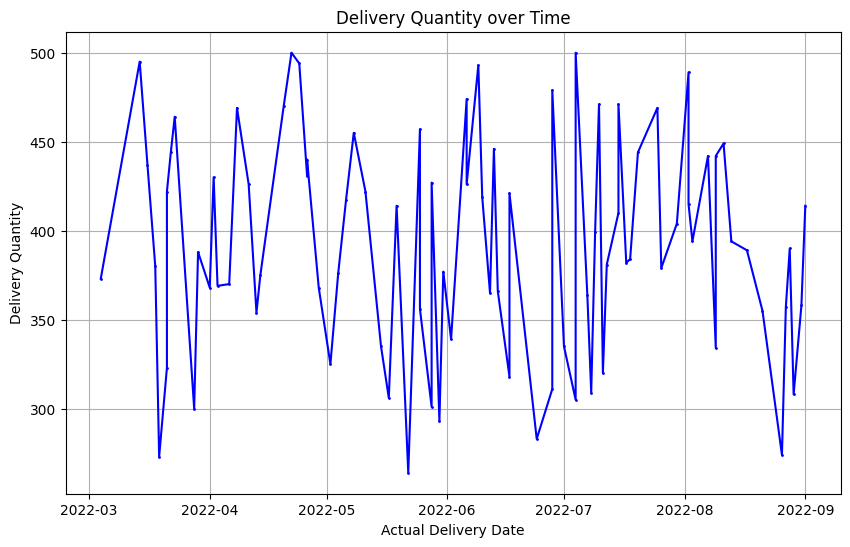

In [10]:
df_sorted_predict = selected_rows.sort_values(by='actual_delivery_date')
plt.figure(figsize=(10, 6))
plt.plot(df_sorted_predict['actual_delivery_date'], df_sorted_predict['delivery_qty'], color='blue', marker='o', linestyle='-', markersize=1)
plt.title('Delivery Quantity over Time')
plt.xlabel('Actual Delivery Date')
plt.ylabel('Delivery Quantity')
plt.grid(True)
plt.show()

In [11]:
df = df_sorted_predict
df.set_index('actual_delivery_date', inplace=True)
df

,order_id,order_placement_date,customer_id,product_id,order_qty,agreed_delivery_date,delivery_qty,in_full,on_time,on_time_in_full,customer_name,city,product_name,category,ontime_target_percent,infull_target_percent,otif_target_percent
actual_delivery_date,,,,,,,,,,,,,,,,,
2022-03-04,FMR35201401,2022-03-04,789201,25891103,373,2022-03-05,373,1,1,1,Rel Fresh,Surat,AM Milk 100,Dairy,87,81,70
2022-03-14,FMR313201103,2022-03-11,789201,25891103,495,2022-03-13,495,1,0,1,Rel Fresh,Surat,AM Milk 100,Dairy,87,81,70
2022-03-16,FMR316201503,2022-03-15,789201,25891103,437,2022-03-16,437,1,1,1,Rel Fresh,Surat,AM Milk 100,Dairy,87,81,70
2022-03-18,FMR318201501,2022-03-16,789201,25891103,422,2022-03-18,380,0,1,0,Rel Fresh,Surat,AM Milk 100,Dairy,87,81,70
2022-03-19,FMR319201402,2022-03-16,789201,25891103,303,2022-03-19,273,0,1,0,Rel Fresh,Surat,AM Milk 100,Dairy,87,81,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-27,FAUG827201402,2022-08-25,789201,25891103,357,2022-08-27,357,1,1,1,Rel Fresh,Surat,AM Milk 100,Dairy,87,81,70
2022-08-28,FAUG828201302,2022-08-25,789201,25891103,390,2022-08-28,390,1,1,1,Rel Fresh,Surat,AM Milk 100,Dairy,87,81,70
2022-08-29,FAUG829201503,2022-08-26,789201,25891103,308,2022-08-29,308,1,1,1,Rel Fresh,Surat,AM Milk 100,Dairy,87,81,70


In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('delivery_qty', axis=1), 
                                                    df['delivery_qty'], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [13]:
reg_model = LinearRegression()
reg_model.fit(X_train[['order_qty']], y_train)

reg_preds = reg_model.predict(X_test[['order_qty']])

reg_mae = mean_absolute_error(y_test, reg_preds)
reg_rmse = mean_squared_error(y_test, reg_preds, squared=False)
print("MAE for regression model:", reg_mae)
print("RMSE for regression model:", reg_rmse)

MAE for regression model: 21.11670167441914
RMSE for regression model: 28.24689980096305


In [14]:
df_comp_reg = pd.DataFrame({"Actual": y_test, "Predict": reg_preds})
df_comp_reg

,Actual,Predict
actual_delivery_date,,
2022-08-09,442,428.269403
2022-03-04,373,363.300975
2022-08-02,489,472.523261
2022-04-26,431,417.912118
2022-04-02,430,416.970546
2022-07-07,364,392.489689
2022-03-29,388,377.424546
2022-04-14,375,365.184118
2022-03-19,273,297.390975


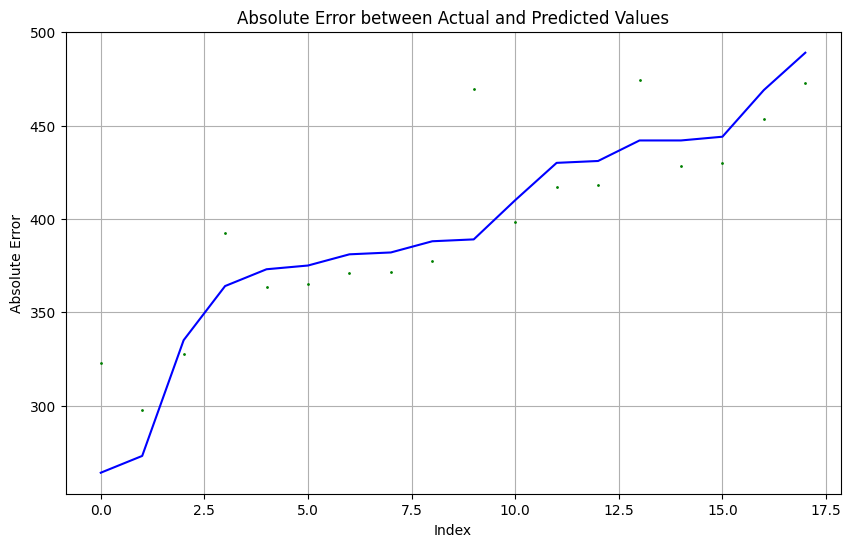

In [15]:
df_comp_reg = pd.concat([X_test, df_comp_reg], axis=1)
df_comp_reg = df_comp_reg.reset_index(drop=True)

df_comp_reg_sorted = df_comp_reg.sort_values(by='Actual')
df_comp_reg_sorted = df_comp_reg_sorted.reset_index(drop=True)
plt.figure(figsize=(10, 6))

plt.plot(df_comp_reg_sorted['Predict'] ,color='green', marker='o', linestyle='', markersize=1)
plt.plot(df_comp_reg_sorted['Actual'], color='blue', label='Actual')

plt.title('Absolute Error between Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ets_model = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='add')
ets_fit = ets_model.fit()
ets_preds = ets_fit.forecast(len(X_test))

ets_mae = mean_absolute_error(y_test, ets_preds)
ets_rmse = mean_squared_error(y_test, ets_preds, squared=False)
print("MAE for regression model:", ets_mae)
print("RMSE for ETS:", ets_rmse)

MAE for regression model: 58.050638518897735
RMSE for ETS: 71.17941959930921


In [17]:
ets_preds.index = y_test.index
df_comp_ets = pd.DataFrame({"Actual": y_test, "Predict": ets_preds})
df_comp_ets

,Actual,Predict
actual_delivery_date,,
2022-08-09,442,429.326601
2022-03-04,373,350.722931
2022-08-02,489,343.956217
2022-04-26,431,388.083065
2022-04-02,430,369.881546
2022-07-07,364,347.401094
2022-03-29,388,372.302198
2022-04-14,375,383.329073
2022-03-19,273,376.081653


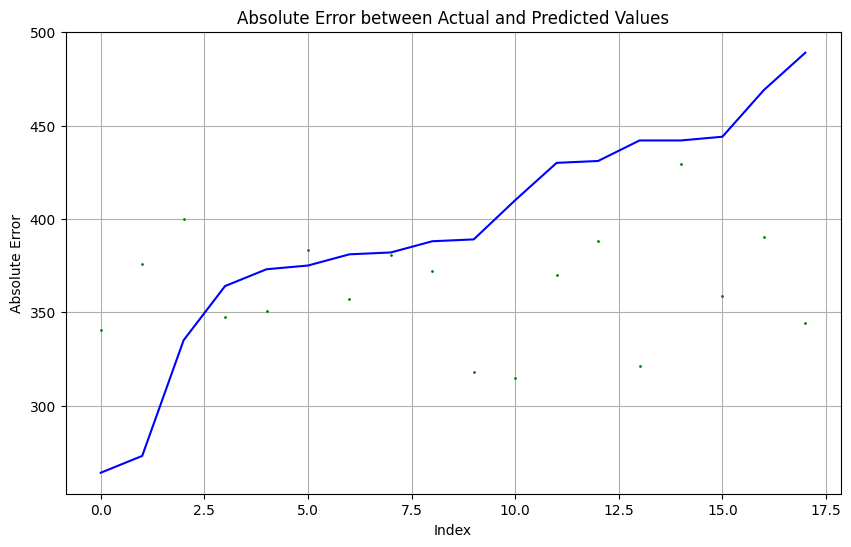

In [18]:
df_comp_ets = pd.concat([X_test, df_comp_ets], axis=1)
df_comp_ets = df_comp_ets.reset_index(drop=True)

df_comp_ets_sorted = df_comp_ets.sort_values(by='Actual')
df_comp_ets_sorted = df_comp_ets_sorted.reset_index(drop=True)
plt.figure(figsize=(10, 6))

plt.plot(df_comp_ets_sorted['Predict'] ,color='green', marker='o', linestyle='', markersize=1)
plt.plot(df_comp_ets_sorted['Actual'], color='blue', label='Actual')

plt.title('Absolute Error between Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

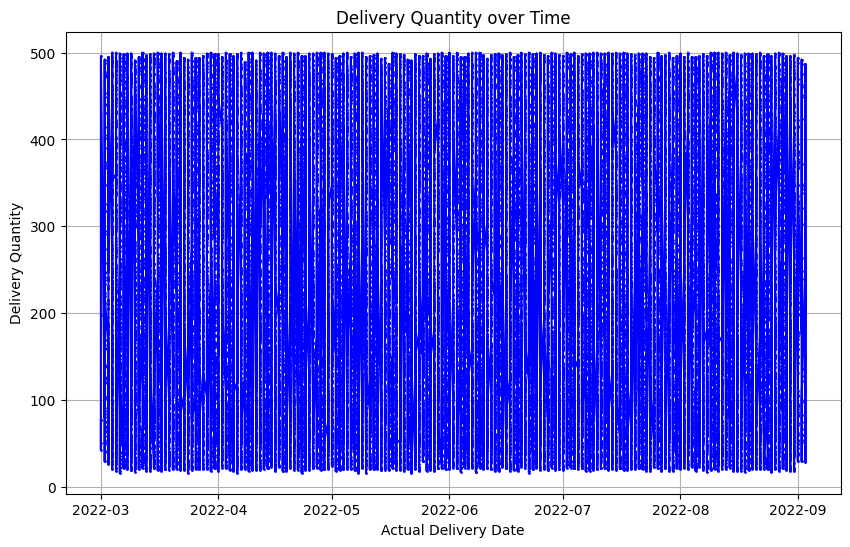

In [19]:
train_SC_sorted_predict = train_SC.sort_values(by='actual_delivery_date')
plt.figure(figsize=(10, 6))
plt.plot(train_SC_sorted_predict['actual_delivery_date'], train_SC_sorted_predict['delivery_qty'], color='blue', marker='o', linestyle='-', markersize=1)
plt.title('Delivery Quantity over Time')
plt.xlabel('Actual Delivery Date')
plt.ylabel('Delivery Quantity')
plt.grid(True)
plt.show()

In [20]:
df_all = train_SC_sorted_predict
df_all.set_index('actual_delivery_date', inplace=True)
df_all

,order_id,order_placement_date,customer_id,product_id,order_qty,agreed_delivery_date,delivery_qty,in_full,on_time,on_time_in_full,customer_name,city,product_name,category,ontime_target_percent,infull_target_percent,otif_target_percent
actual_delivery_date,,,,,,,,,,,,,,,,,
2022-03-01,FMR32103602,2022-03-01,789103,25891602,86,2022-03-02,77,0,1,0,Vijay Stores,Vadodara,AM Tea 250,Beverages,92,67,62
2022-03-01,FMR32622503,2022-03-01,789622,25891503,208,2022-03-02,198,0,1,0,Expert Mart,Vadodara,AM Biscuits 250,Food,90,79,71
2022-03-01,FMR32221303,2022-03-01,789221,25891303,42,2022-03-02,42,1,1,1,Atlas Stores,Ahmedabad,AM Ghee 100,Dairy,85,80,68
2022-03-01,FMR32501201,2022-03-01,789501,25891201,273,2022-03-02,273,1,1,1,Viveks Stores,Surat,AM Butter 100,Dairy,92,80,74
2022-03-01,FMR32220602,2022-03-01,789220,25891602,77,2022-03-02,77,1,1,1,Atlas Stores,Surat,AM Tea 250,Beverages,91,76,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-03,FAUG831402401,2022-08-28,789402,25891401,485,2022-08-31,485,1,0,1,Propel Mart,Ahmedabad,AM Curd 250,Dairy,89,80,71
2022-09-03,FAUG831420502,2022-08-30,789420,25891502,198,2022-08-31,198,1,0,1,Lotus Mart,Surat,AM Biscuits 500,Food,75,79,59
2022-09-03,FAUG831121402,2022-08-29,789121,25891402,227,2022-08-31,227,1,0,1,Coolblue,Ahmedabad,AM Curd 100,Dairy,78,77,60


In [21]:
X_train, X_test, y_train, y_test = train_test_split(df_all.drop('delivery_qty', axis=1), 
                                                    df_all['delivery_qty'], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [22]:
reg_model = LinearRegression()
reg_model.fit(X_train[['order_qty']], y_train)

reg_preds = reg_model.predict(X_test[['order_qty']])

reg_mae = mean_absolute_error(y_test, reg_preds)
reg_rmse = mean_squared_error(y_test, reg_preds, squared=False)
print("MAE for regression model:", reg_mae)
print("RMSE for regression model:", reg_rmse)

MAE for regression model: 10.596776559552014
RMSE for regression model: 15.68196037213407


In [23]:
df_all_comp_reg = pd.DataFrame({"Actual": y_test, "Predict": reg_preds})
df_all_comp_reg

,Actual,Predict
actual_delivery_date,,
2022-06-19,254,272.358827
2022-05-03,488,471.283102
2022-07-07,97,98.541500
2022-04-13,136,131.373662
2022-06-09,317,306.156641
...,...,...
2022-07-07,113,109.163670
2022-05-02,210,213.454066
2022-07-12,121,116.888884


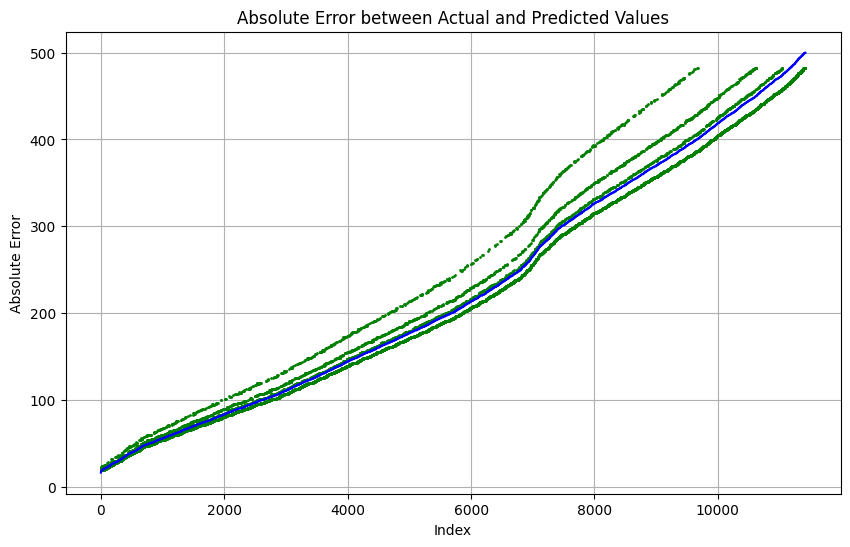

In [24]:
df_all_comp_reg = pd.concat([X_test, df_all_comp_reg], axis=1)
df_all_comp_reg = df_all_comp_reg.reset_index(drop=True)

df_all_comp_reg_sorted = df_all_comp_reg.sort_values(by='Actual')
df_all_comp_reg_sorted = df_all_comp_reg_sorted.reset_index(drop=True)
plt.figure(figsize=(10, 6))

plt.plot(df_all_comp_reg_sorted['Predict'] ,color='green', marker='o', linestyle='', markersize=1)
plt.plot(df_all_comp_reg_sorted['Actual'], color='blue', label='Actual')

plt.title('Absolute Error between Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

In [25]:
ets_model = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='add')
ets_fit = ets_model.fit()
ets_preds = ets_fit.forecast(len(X_test))

ets_mae = mean_absolute_error(y_test, ets_preds)
ets_rmse = mean_squared_error(y_test, ets_preds, squared=False)
print("MAE for regression model:", ets_mae)
print("RMSE for ETS:", ets_rmse)

MAE for regression model: 1344.6194044781796
RMSE for ETS: 1542.8865735957306


In [26]:
ets_preds.index = y_test.index
df_all_comp_ets = pd.DataFrame({"Actual": y_test, "Predict": ets_preds})
df_all_comp_ets

,Actual,Predict
actual_delivery_date,,
2022-06-19,254,160.396953
2022-05-03,488,158.012904
2022-07-07,97,161.136751
2022-04-13,136,178.831747
2022-06-09,317,170.242202
...,...,...
2022-07-07,113,-2398.634938
2022-05-02,210,-2407.224483
2022-07-12,121,-2404.393594


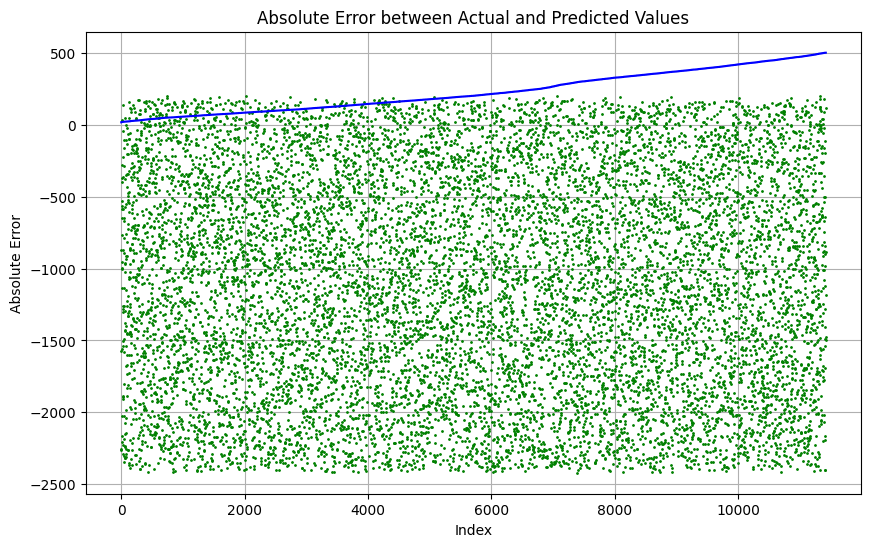

In [27]:
df_all_comp_ets = pd.concat([X_test, df_all_comp_ets], axis=1)
df_all_comp_ets = df_all_comp_ets.reset_index(drop=True)

df_all_comp_ets_sorted = df_all_comp_ets.sort_values(by='Actual')
df_all_comp_ets_sorted = df_all_comp_ets_sorted.reset_index(drop=True)
plt.figure(figsize=(10, 6))

plt.plot(df_all_comp_ets_sorted['Predict'] ,color='green', marker='o', linestyle='', markersize=1)
plt.plot(df_all_comp_ets_sorted['Actual'], color='blue', label='Actual')

plt.title('Absolute Error between Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

## ETS

In [28]:
df_ets = selected_rows.sort_values(by='order_placement_date')
df_ets

,order_id,order_placement_date,customer_id,product_id,order_qty,agreed_delivery_date,actual_delivery_date,delivery_qty,in_full,on_time,on_time_in_full,customer_name,city,product_name,category,ontime_target_percent,infull_target_percent,otif_target_percent
52360,FMR35201401,2022-03-04,789201,25891103,373,2022-03-05,2022-03-04,373,1,1,1,Rel Fresh,Surat,AM Milk 100,Dairy,87,81,70
52361,FMR313201103,2022-03-11,789201,25891103,495,2022-03-13,2022-03-14,495,1,0,1,Rel Fresh,Surat,AM Milk 100,Dairy,87,81,70
52362,FMR316201503,2022-03-15,789201,25891103,437,2022-03-16,2022-03-16,437,1,1,1,Rel Fresh,Surat,AM Milk 100,Dairy,87,81,70
52363,FMR318201501,2022-03-16,789201,25891103,422,2022-03-18,2022-03-18,380,0,1,0,Rel Fresh,Surat,AM Milk 100,Dairy,87,81,70
52364,FMR319201402,2022-03-16,789201,25891103,303,2022-03-19,2022-03-19,273,0,1,0,Rel Fresh,Surat,AM Milk 100,Dairy,87,81,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52441,FAUG827201402,2022-08-25,789201,25891103,357,2022-08-27,2022-08-27,357,1,1,1,Rel Fresh,Surat,AM Milk 100,Dairy,87,81,70
52442,FAUG828201302,2022-08-25,789201,25891103,390,2022-08-28,2022-08-28,390,1,1,1,Rel Fresh,Surat,AM Milk 100,Dairy,87,81,70
52443,FAUG829201503,2022-08-26,789201,25891103,308,2022-08-29,2022-08-29,308,1,1,1,Rel Fresh,Surat,AM Milk 100,Dairy,87,81,70
52444,FAUG830201103,2022-08-28,789201,25891103,414,2022-08-30,2022-09-01,414,1,0,1,Rel Fresh,Surat,AM Milk 100,Dairy,87,81,70


In [29]:
# Grouping by product_category_id and counting unique week numbers
order_date_counts = df_ets.groupby('product_name')['order_placement_date'].nunique()


# Finding the product category with the highest count of unique week numbers
max_date_count_order = order_date_counts.max()
max_date_count_order_id = order_date_counts.idxmax()

print(max_date_count_order_id, max_date_count_order)

AM Milk 100 77


In [30]:
grouped_product_date = df_ets.groupby(['product_name', 'order_placement_date'])['order_qty'].sum().reset_index()
grouped_product_date

,product_name,order_placement_date,order_qty
0,AM Milk 100,2022-03-04,373
1,AM Milk 100,2022-03-11,495
2,AM Milk 100,2022-03-15,437
3,AM Milk 100,2022-03-16,725
4,AM Milk 100,2022-03-18,745
...,...,...,...
72,AM Milk 100,2022-08-23,304
73,AM Milk 100,2022-08-25,747
74,AM Milk 100,2022-08-26,308
75,AM Milk 100,2022-08-28,414


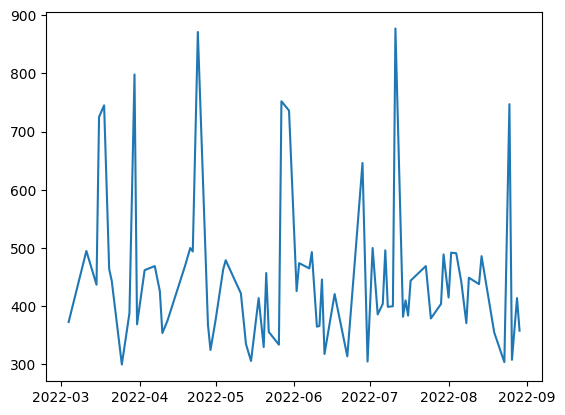

In [31]:
plt.plot(grouped_product_date["order_placement_date"], grouped_product_date["order_qty"])

In [32]:
am_milk_100 =  grouped_product_date[grouped_product_date['product_name'] == 'AM Milk 100']

latest_date = am_milk_100['order_placement_date'].max()
split_date = latest_date - timedelta(days=30)

train_data = am_milk_100[am_milk_100['order_placement_date'] < split_date]
test_data = am_milk_100[am_milk_100['order_placement_date'] >= split_date]

train_data_100 = train_data[train_data['product_name'] == 'AM Milk 100']
train_data_100.set_index('order_placement_date', inplace=True)
test_data_100 = test_data[test_data['product_name'] == 'AM Milk 100']
test_data_100.set_index('order_placement_date', inplace=True)

actual_data_100 = am_milk_100[am_milk_100['product_name'] == 'AM Milk 100']
actual_data_100.set_index('order_placement_date', inplace=True)

train_data_100 = train_data_100.drop(['product_name'], axis=1)
test_data_100 = test_data_100.drop(['product_name'], axis=1)
actual_data_100 = actual_data_100.drop(['product_name'], axis=1)

In [34]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

def forecast_plot(fcast, color):
    forecast_index = pd.date_range(start='2022-07-30', periods=len(fcast), freq='D')
    forecast_df = pd.DataFrame({'Forecast': fcast.values}, index=forecast_index)
    plt.plot(forecast_df, color=color)

def y_test_change(fcast, y_test):
    df1 = y_test
    df2 = fcast

    if len(df2) > len(df1):
        df2 = df2[:len(df1)]
    elif len(df2) < len(df1):
        raise ValueError('The length of the series in data2 is shorter than the length of data1')

    df2.index = df1.index
    df1 = pd.Series(df1['order_qty'])
    return df1, df2

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(color='black', legend=True, figsize=(16, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    line1, = plt.plot(fit1.fittedvalues, color="blue")
    forecast_plot(fcast1, "blue")
    y_to_test_1, fcast1 = y_test_change(fcast1, y_to_test)
    mse1 = ((fcast1 - y_to_test_1) ** 2).mean()
    print('The RMSE of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    line2, = plt.plot(fit2.fittedvalues, color="red")
    forecast_plot(fcast2, "red")
    y_to_test_2, fcast2 = y_test_change(fcast2, y_to_test)
    mse2 = ((fcast2 - y_to_test_2) ** 2).mean()
    print('The RMSE of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.legend([line1, line2], [fcast1.name, fcast2.name])
    plt.show()

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(color='black', legend=True, figsize=(16, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    forecast_plot(fcast1, "blue")
    y_to_test_1, fcast1 = y_test_change(fcast1, y_to_test)
    mse1 = ((fcast1 - y_to_test_1) ** 2).mean()
    print('The RMSE of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    forecast_plot(fcast2, "red")
    y_to_test_2, fcast2 = y_test_change(fcast2, y_to_test)
    mse2 = ((fcast2 - y_to_test_2) ** 2).mean()
    print('The RMSE of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    line1, = plt.plot(fit1.fittedvalues, color="blue")
    line2, = plt.plot(fit2.fittedvalues, color="red")
    plt.legend([line1, line2], [fcast1.name, fcast2.name])
    plt.show()

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(color='black', legend=True, figsize=(16, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', use_boxcox=True).fit()
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        forecast_plot(fcast1, "blue")
        y_to_test_1, fcast1 = y_test_change(fcast1, y_to_test)
        mse1 = ((fcast1 - y_to_test_1) ** 2).mean()
        print('The RMSE of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True, use_boxcox=True).fit()
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        forecast_plot(fcast2, "red")
        y_to_test_2, fcast2 = y_test_change(fcast2, y_to_test)
        mse2 = ((fcast2 - y_to_test_2) ** 2).mean()
        print('The RMSE of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        line1, = plt.plot(fit1.fittedvalues, color="blue")
        line2, = plt.plot(fit2.fittedvalues, color="red")
        plt.legend([line1, line2], [fcast1.name, fcast2.name])
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', use_boxcox=True).fit()
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        forecast_plot(fcast3, "blue")
        y_to_test_3, fcast3 = y_test_change(fcast3, y_to_test)
        mse3 = ((fcast3 - y_to_test_3) ** 2).mean()
        print('The RMSE of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True, use_boxcox=True).fit()
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        forecast_plot(fcast4, "red")
        y_to_test_4, fcast4 = y_test_change(fcast4, y_to_test)
        mse4 = ((fcast4 - y_to_test_4) ** 2).mean()
        print('The RMSE of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        line3, = plt.plot(fit3.fittedvalues, color="blue")
        line4, = plt.plot(fit4.fittedvalues, color="red")
        plt.legend([line3, line4], [fcast3.name, fcast4.name])
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

The RMSE of our forecasts with smoothing level of 0.8 is 109.03
The RMSE of our forecasts with auto optimization is 103.49


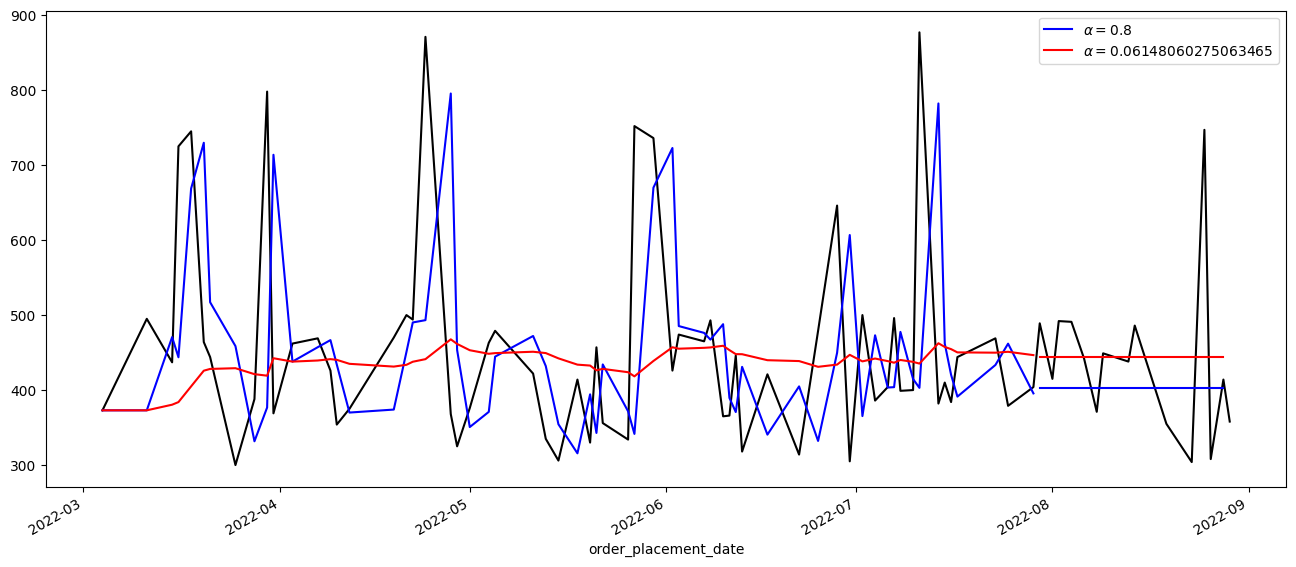

The RMSE of Holts Linear trend 152.77
The RMSE of Holts Exponential trend 119.9


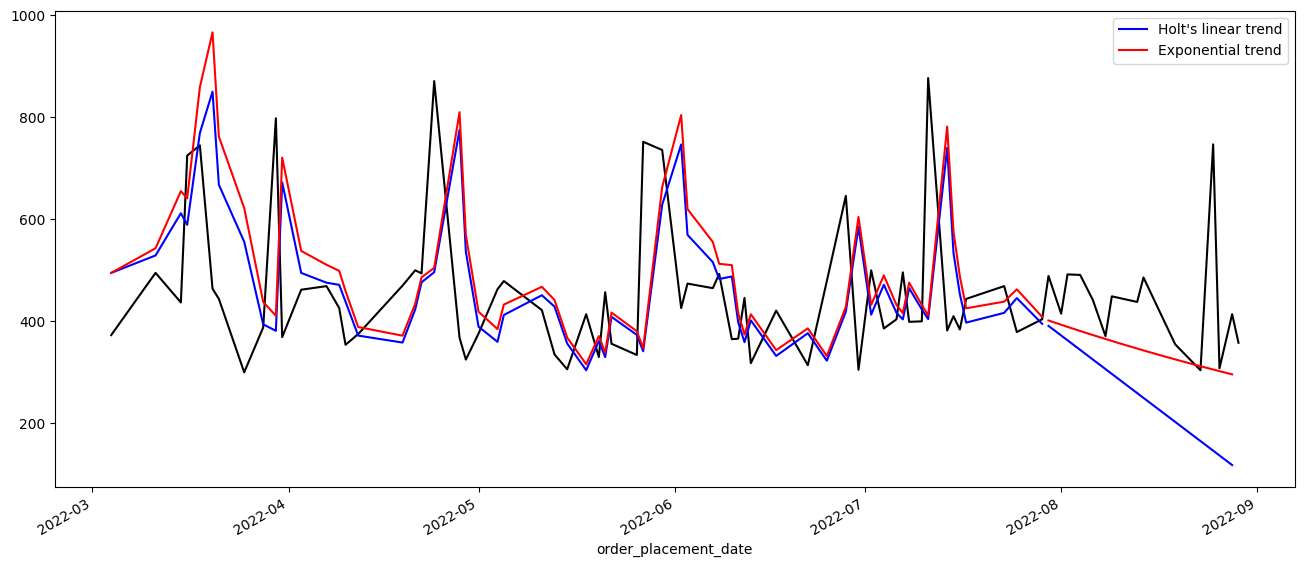

The RMSE of additive trend, additive seasonal of period season_length=4 and a Box-Cox transformation 97.2
The RMSE of additive damped trend, additive seasonal of period season_length=4 and a Box-Cox transformation 98.59


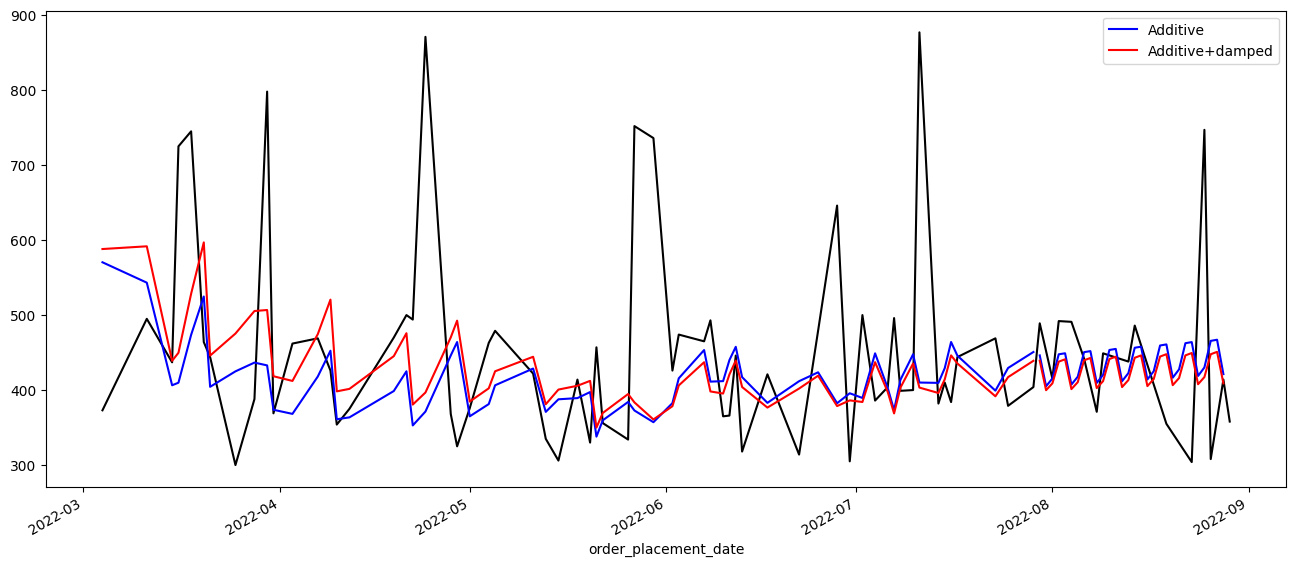

The RMSE of additive trend, multiplicative seasonal of period season_length=4 and a Box-Cox transformation 97.2
The RMSE of additive damped trend, multiplicative seasonal of period season_length=4 and a Box-Cox transformation 98.58


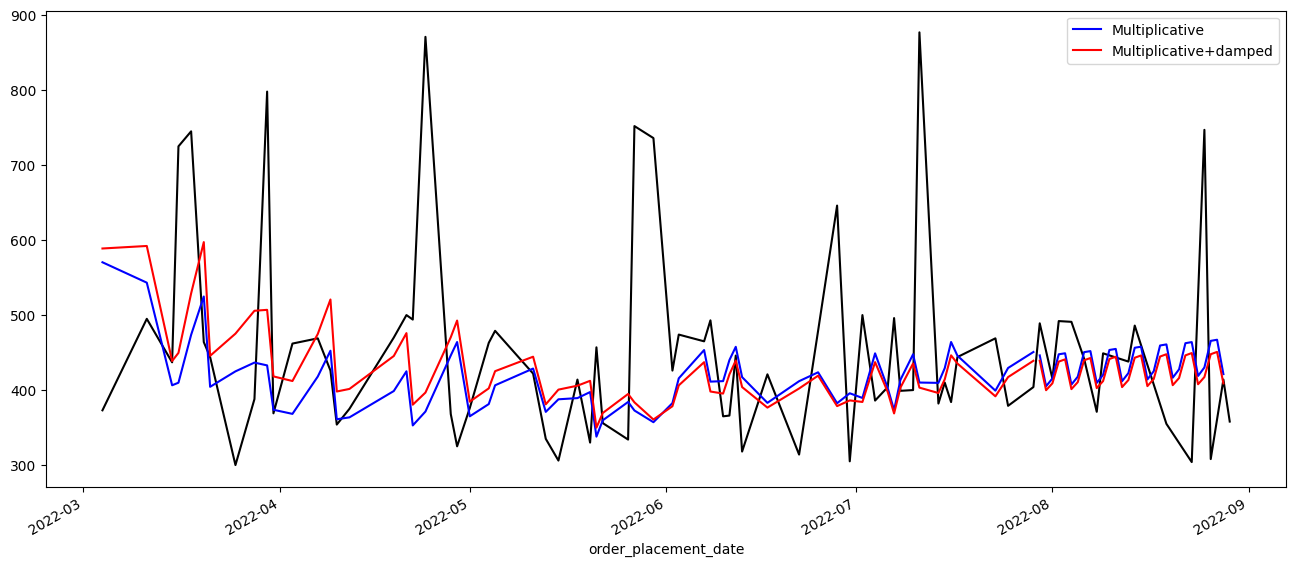

In [35]:
ses(actual_data_100, train_data_100, test_data_100, 0.8, 30)
holt(actual_data_100, train_data_100, test_data_100, 0.6, 0.2, 30)
holt_win_sea(actual_data_100, train_data_100, test_data_100, 'additive', 4, 30)
holt_win_sea(actual_data_100, train_data_100, test_data_100, 'multiplicative', 4, 30)

The RMSE of additive trend, additive seasonal of period season_length=8 and a Box-Cox transformation 87.16
The RMSE of additive damped trend, additive seasonal of period season_length=8 and a Box-Cox transformation 86.75


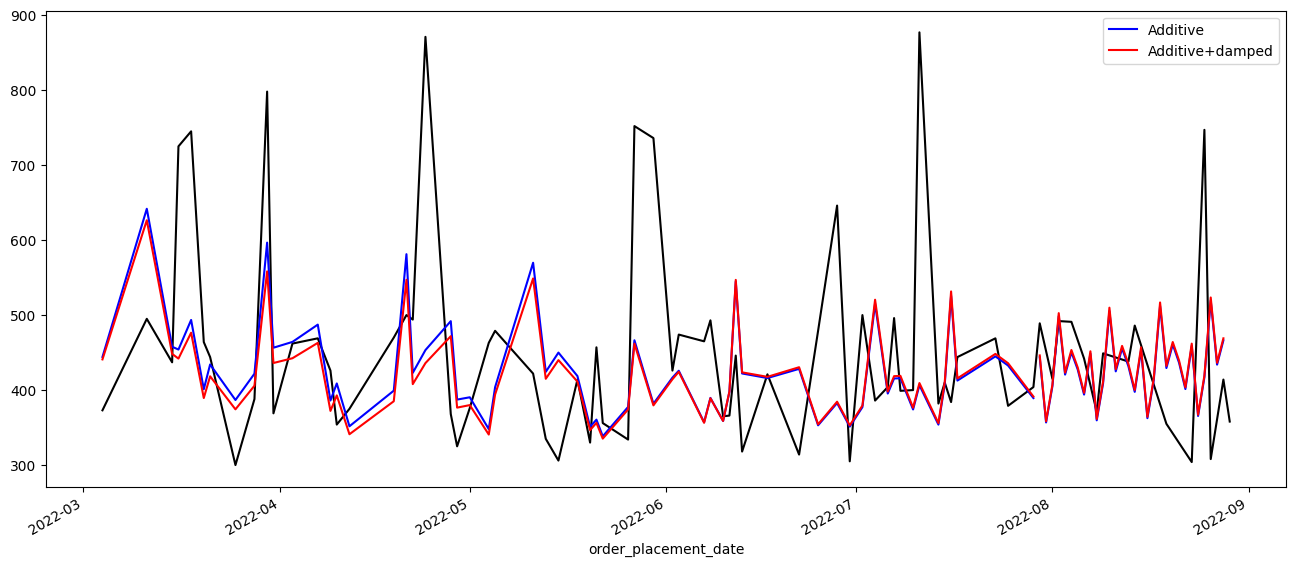

In [36]:
holt_win_sea(actual_data_100, train_data_100, test_data_100, 'additive', 8, 30)

## Holt's Method

In [37]:
# Holt's Method
fit1 = Holt(df_2, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast1 = fit1.forecast(5).rename("Holt's linear trend")
fit2 = Holt(df_2, exponential=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast2 = fit2.forecast(5).rename("Exponential trend")
fit3 = Holt(df_2, damped_trend=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2
)
fcast3 = fit3.forecast(5).rename("Additive damped trend")

plt.figure(figsize=(12, 8))
plt.plot(df_2, marker="o", color="black")
line1, = plt.plot(fit1.fittedvalues, marker="o", color="blue")
line2, = plt.plot(fit2.fittedvalues, marker="o", color="red")
line3, = plt.plot(fit3.fittedvalues, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])


NameError: name 'df_2' is not defined

In [ ]:
# Seasonally adjusted data
fit1 = SimpleExpSmoothing(df_2, initialization_method="estimated").fit()
fit2 = Holt(df_2, initialization_method="estimated").fit()
fit3 = Holt(df_2, exponential=True, initialization_method="estimated").fit()
fit4 = Holt(df_2, damped_trend=True, initialization_method="estimated").fit(
    damping_trend=0.98
)
fit5 = Holt(
    df_2, exponential=True, damped_trend=True, initialization_method="estimated"
).fit()
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "initial_level",
    "initial_trend",
]
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$l_0$", "$b_0$", "SSE"],
    columns=["SES", "Holt's", "Exponential", "Additive", "Multiplicative"],
)
results["SES"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Holt's"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Exponential"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Additive"] = [fit4.params[p] for p in params] + [fit4.sse]
results["Multiplicative"] = [fit5.params[p] for p in params] + [fit5.sse]
results


,SES,Holt's,Exponential,Additive,Multiplicative
$\alpha$,0.056707,0.194548,0.193571,0.169782,0.170000
$\beta$,NaN,0.032621,0.032262,0.019949,0.020000
$\phi$,NaN,NaN,NaN,0.980000,0.990000
$l_0$,402.063002,425.487099,425.599999,425.565280,425.600000
$b_0$,NaN,-0.191929,1.000607,-0.681803,1.014390
SSE,315588.048100,338434.431802,338636.523583,332552.465664,336092.116602


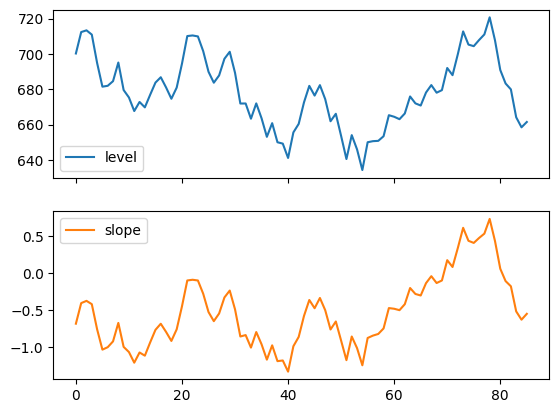

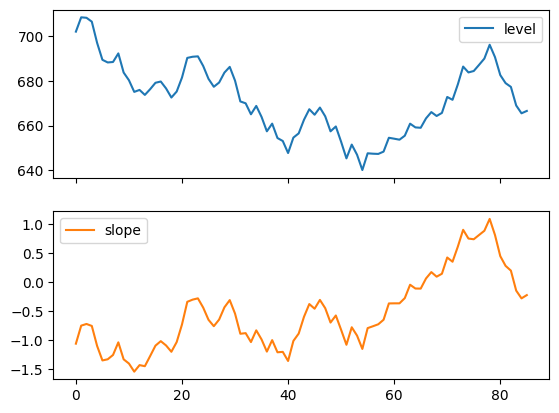

In [ ]:
for fit in [fit2, fit4]:
    pd.DataFrame(np.c_[fit.level, fit.trend]).rename(
        columns={0: "level", 1: "slope"}
    ).plot(subplots=True)
plt.show()
# print("Figure 7.4: Level and slope components for Holt’s linear trend method and the additive damped trend method.")

## Holt-Winter's Method

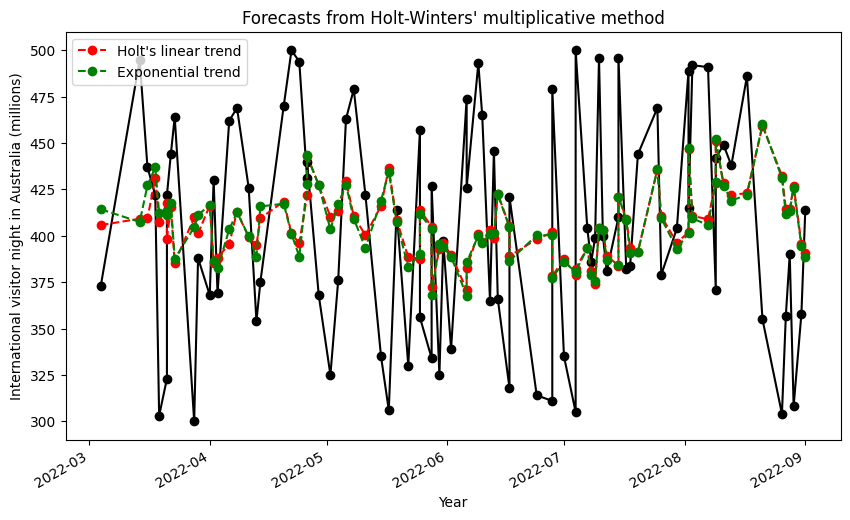

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,0.073623,0.075722,0.069197,0.040394
$\beta$,0.030527,0.021636,0.008962,0.040394
$\phi$,NaN,NaN,0.979054,0.990000
$\gamma$,0.099953,0.102791,0.094132,0.102944
$l_0$,724.566220,706.683581,717.963961,706.788153
$b_0$,-0.300018,-0.555192,-0.615207,-0.909432
SSE,343056.025423,342977.471134,335578.673575,340460.806678


In [ ]:
fit1 = ExponentialSmoothing(
    df_2,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit2 = ExponentialSmoothing(
    df_2,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit3 = ExponentialSmoothing(
    df_2,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit4 = ExponentialSmoothing(
    df_2,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = df_2.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")
line1, = plt.plot(fit1.fittedvalues, marker="o", linestyle="dashed", color="red")
line2, = plt.plot(fit2.fittedvalues, marker="o", linestyle="dashed", color="green")

# fit1.forecast(8).rename("Holt-Winters (add-add-seasonal)").plot(
#     ax=ax, style="--", marker="o", color="red", legend=True
# )
# fit2.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
#     ax=ax, style="--", marker="o", color="green", legend=True
# )

plt.legend([line1, line2], [fcast1.name, fcast2.name])
plt.show()
results


## By product

In [ ]:
train_SC_sorted_predict = train_SC.sort_values(by='agreed_delivery_date')
df_by_product = train_SC_sorted_predict[['agreed_delivery_date', 'product_name', 'order_qty']]
df_by_product

,agreed_delivery_date,product_name,order_qty
0,2022-03-02,AM Butter 500,460
14651,2022-03-02,AM Butter 500,478
14553,2022-03-02,AM Curd 50,441
42587,2022-03-02,AM Milk 100,430
9030,2022-03-02,AM Butter 250,178
...,...,...,...
41526,2022-08-31,AM Tea 500,100
56652,2022-08-31,AM Butter 100,369
51037,2022-08-31,AM Tea 100,93
8023,2022-08-31,AM Ghee 100,93


In [ ]:
df_by_product['days_since_earliest'] = (df_by_product['agreed_delivery_date'] - df_by_product['agreed_delivery_date'].min()).dt.days
df_by_product

,agreed_delivery_date,product_name,order_qty,days_since_earliest
0,2022-03-02,AM Butter 500,460,0
14651,2022-03-02,AM Butter 500,478,0
14553,2022-03-02,AM Curd 50,441,0
42587,2022-03-02,AM Milk 100,430,0
9030,2022-03-02,AM Butter 250,178,0
...,...,...,...,...
41526,2022-08-31,AM Tea 500,100,182
56652,2022-08-31,AM Butter 100,369,182
51037,2022-08-31,AM Tea 100,93,182
8023,2022-08-31,AM Ghee 100,93,182


In [ ]:
latest_date = df_by_product['agreed_delivery_date'].max()
split_date = latest_date - timedelta(days=30)

train_data = df_by_product[df_by_product['agreed_delivery_date'] < split_date]
test_data = df_by_product[df_by_product['agreed_delivery_date'] >= split_date]

train_data.set_index('agreed_delivery_date', inplace=True)
test_data.set_index('agreed_delivery_date', inplace=True)

X_train = train_data[['product_name']]
y_train = train_data['order_qty']

X_test = test_data[['product_name']]
y_test = test_data['order_qty']

In [ ]:
label_encoder = LabelEncoder()
X_train['product_name_encoded'] = label_encoder.fit_transform(X_train['product_name'])
X_test['product_name_encoded'] = label_encoder.transform(X_test['product_name'])

X_train.drop(columns=['product_name'], inplace=True)
X_test.drop(columns=['product_name'], inplace=True)

In [ ]:
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

reg_preds = reg_model.predict(X_test)

reg_mae = mean_absolute_error(y_test, reg_preds)
reg_rmse = mean_squared_error(y_test, reg_preds, squared=False)
print("MAE for regression model:", reg_mae)
print("RMSE for regression model:", reg_rmse)

MAE for regression model: 123.68091435187614
RMSE for regression model: 141.12978901451277


In [ ]:
df_by_product_reg = pd.DataFrame({"Actual": y_test, "Predict": reg_preds})
df_by_product_reg

,Actual,Predict
agreed_delivery_date,,
2022-08-01,374,242.290547
2022-08-01,234,253.220050
2022-08-01,215,253.220050
2022-08-01,416,242.290547
2022-08-01,285,237.918746
...,...,...
2022-08-31,100,216.059741
2022-08-31,369,246.662348
2022-08-31,93,220.431542


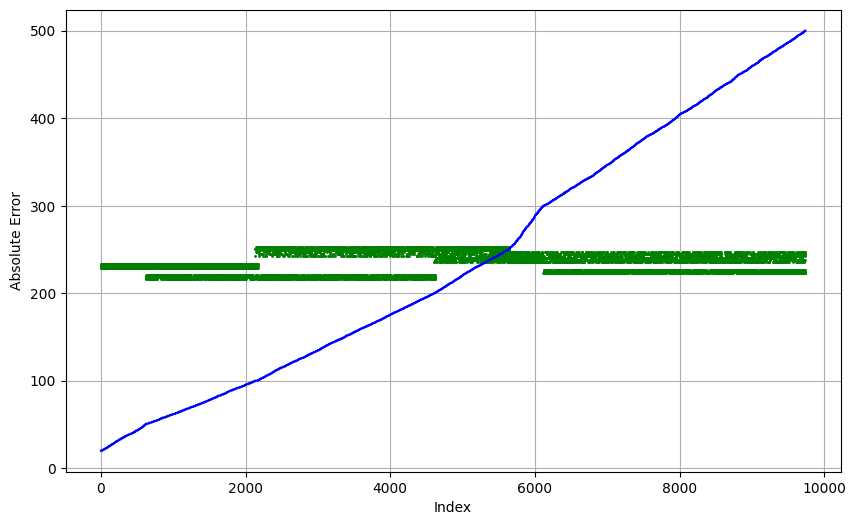

In [ ]:
df_by_product_reg_concat = pd.concat([X_test, df_by_product_reg], axis=1)
df_by_product_reg_concat = df_by_product_reg_concat.reset_index(drop=True)

df_by_product_reg_concat = df_by_product_reg_concat.sort_values(by='Actual')
df_by_product_reg_concat = df_by_product_reg_concat.reset_index(drop=True)
plt.figure(figsize=(10, 6))

plt.plot(df_by_product_reg_concat['Predict'] ,color='green', marker='o', linestyle='', markersize=1)
plt.plot(df_by_product_reg_concat['Actual'], color='blue', label='Actual')

plt.xlabel('Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

### Simple Exponential Smoothing

In [ ]:
df_sorted_predict = train_SC.sort_values(by='agreed_delivery_date')
# df_sorted_predict.set_index('agreed_delivery_date', inplace=True)
df_agreed = df_sorted_predict[['agreed_delivery_date', 'product_name', 'order_qty']]
df_agreed

,agreed_delivery_date,product_name,order_qty
0,2022-03-02,AM Butter 500,460
14651,2022-03-02,AM Butter 500,478
14553,2022-03-02,AM Curd 50,441
42587,2022-03-02,AM Milk 100,430
9030,2022-03-02,AM Butter 250,178
...,...,...,...
41526,2022-08-31,AM Tea 500,100
56652,2022-08-31,AM Butter 100,369
51037,2022-08-31,AM Tea 100,93
8023,2022-08-31,AM Ghee 100,93


In [ ]:
latest_date = df_agreed['agreed_delivery_date'].max()
split_date = latest_date - timedelta(days=30)

train_data = df_agreed[df_agreed['agreed_delivery_date'] < split_date]
test_data = df_agreed[df_agreed['agreed_delivery_date'] >= split_date]

train_data = train_data.groupby(['agreed_delivery_date', 'product_name']).sum()
test_data = test_data.groupby(['agreed_delivery_date', 'product_name']).sum()

In [ ]:
# Train the simple exponential smoothing model
trained_models = {}
for product in train_data.index.get_level_values('product_name').unique():
    ts = train_data.loc(axis=0)[:, product]['order_qty']
    model = SimpleExpSmoothing(ts)
    model_fit = model.fit(smoothing_level=0.2)
    trained_models[product] = model_fit

# Generate forecasts for the test data
test_forecasts = {}
for product in test_data.index.get_level_values('product_name').unique():
    ts = test_data.loc(axis=0)[:, product]['order_qty']
    model_fit = trained_models[product]
    forecast = model_fit.forecast(len(ts))
    test_forecasts[product] = forecast

# Evaluate the model using mean absolute error (MAE)
mae_scores = []
for product in test_data.index.get_level_values('product_name').unique():
    actual_values = test_data.loc(axis=0)[:, product]['order_qty']
    forecast_values = test_forecasts[product]
    mae = mean_absolute_error(actual_values, forecast_values)
    mae_scores.append(mae)

In [ ]:
overall_mae = sum(mae_scores) / len(mae_scores)
print("Overall MAE:", overall_mae)

Overall MAE: 613.4734831590042


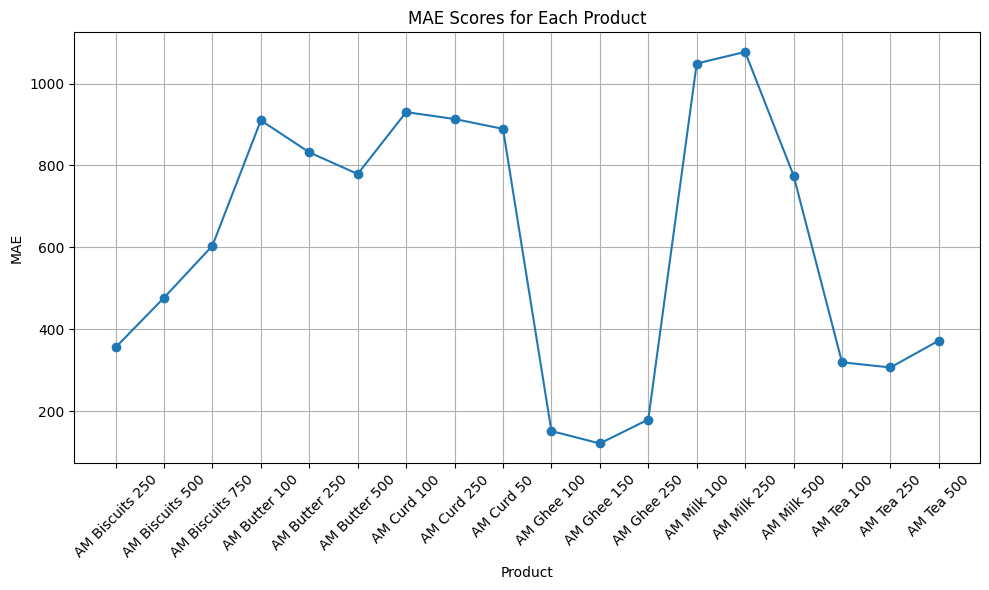

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mae_scores) + 1), mae_scores, marker='o', linestyle='-')
plt.title('MAE Scores for Each Product')
plt.xlabel('Product')
plt.ylabel('MAE')
plt.xticks(range(1, len(mae_scores) + 1), labels=test_data.index.get_level_values('product_name').unique(), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()